# pylibCZIrw Demo

In this notebook one can see how to read and write czis using pylibCZIrw.

At the moment, pylibCZIrw completely abstracts away the subblock concept, both in the reading and in the writing APIs.
If pylibCZIrw is extended in the future to support subblock-based access (e.g. accessing acquisition tiles),
this API must not be altered.

## Reading a CZI file

Both the reading and writing APIs are contained within the czi object in pylibCZIrw, so let's start by importing it.

In [1]:
# !pip install ipyfilechooser

# show the used python env
import sys
print("Using:", sys.executable)

from pylibCZIrw import czi as pyczi
from ipyfilechooser import FileChooser
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from typing import List, NamedTuple

Using: C:\Users\m1srh\Miniconda3\envs\napari-src\python.exe


### Open a CZI image file read metadata

We can open a czi using a context manager and then read the required data.
The full metadata of the czi can be read as an XML or a dictionary

In [2]:
# define the filename
czifile_scenes = r"w96_A1+A2.czi"
czifile_5dstack = r"T=3_Z=5_CH=2_X=240_Y=170.czi"


with pyczi.open_czi(czifile_5dstack) as czidoc:
    # get the raw metadata as XML
    md_xml = czidoc.raw_metadata
    print(md_xml)

<?xml version="1.0"?>
<ImageDocument>
 <Metadata>
  <Experiment Version="1.1">
   <RunMode>OptimizeBeforePerformEnabled,ValidateAndAdaptBeforePerformEnabled</RunMode>
   <BeforeHardwareSetting>Before Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</BeforeHardwareSetting>
   <AfterHardwareSetting>After Exp [AF635, AF555, AF594, AF514, AF405, PGC] Smart</AfterHardwareSetting>
   <ExperimentBlockIndex>0</ExperimentBlockIndex>
   <IsSegmented>false</IsSegmented>
   <IsStandardMode>true</IsStandardMode>
   <ImageTransferMode>MemoryMappedAndFileStream</ImageTransferMode>
   <AutoSave IsActivated="false" EnableSingleFileSave="false">
    <StorageFolder>D:\Users\zeiss\Pictures</StorageFolder>
    <Name>New</Name>
    <IsAutoSubFolder>true</IsAutoSubFolder>
    <IsAutoSubFolderExternal>true</IsAutoSubFolderExternal>
    <IsClosedOnCompletion>false</IsClosedOnCompletion>
    <SingleFileSaveFormat>JPG</SingleFileSaveFormat>
    <ConvertTo8Bit>false</ConvertTo8Bit>
    <AddXmlMetadata>false</Ad

In [3]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the raw metadata as a dictionary
    md_dict = czidoc.metadata
    
    # show some parts of it
    print(json.dumps(md_dict["ImageDocument"]["Metadata"]["Information"]["Image"], sort_keys=False, indent=2))

{
  "SizeX": "21718",
  "SizeY": "1440",
  "SizeS": "2",
  "SizeB": "1",
  "SizeM": "1",
  "OriginalCompressionMethod": "Uncompressed",
  "OriginalEncodingQuality": "100",
  "AcquisitionDateAndTime": "2016-07-04T14:52:08.4473414Z",
  "SizeC": "2",
  "ComponentBitCount": "14",
  "PixelType": "Gray16",
  "Dimensions": {
    "Channels": {
      "Channel": [
        {
          "@Id": "Channel:0",
          "@Name": "AF568",
          "ExcitationWavelength": "577",
          "EmissionWavelength": "603",
          "DyeId": "McNamara-Boswell-0049",
          "DyeDatabaseId": "66071726-cbd4-4c41-b371-0a6eee4ae9c5",
          "Color": "#FFFF1800",
          "Fluor": "Alexa Fluor 568",
          "ExposureTime": "150000000",
          "IlluminationType": "Epifluorescence",
          "ContrastMethod": "Fluorescence",
          "PixelType": "Gray16",
          "ComponentBitCount": "14",
          "AcquisitionMode": "WideField",
          "IlluminationWavelength": {
            "SinglePeak": "567",

## Get Image dimensions
There are different properties that allow us to know about the dimensions of the czi file.
The total bounding box gives us all the dimensions of all orthogonal planes of the CZI.

In [4]:
with pyczi.open_czi(czifile_5dstack) as czidoc:

    # get the image dimensions as an dictionary, where the key identifies the dimension
    total_bounding_box = czidoc.total_bounding_box
    print(total_bounding_box)

{'T': (0, 3), 'Z': (0, 5), 'C': (0, 2), 'B': (0, 1), 'X': (0, 240), 'Y': (0, 170)}


The total bounding rectangle gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the total bounding box.

In [5]:
with pyczi.open_czi(czifile_scenes) as czidoc:

    # get the total bounding box for all scenes
    total_bounding_rectangle = czidoc.total_bounding_rectangle
    print(total_bounding_rectangle)

Rectangle(x=0, y=0, w=21718, h=1440)


Scenes are not orthogonal to the other dimensions. They are contained within the 2D planes and can be seen simply as tags.
The scene bounding rectangles give us the bounding rectangle for each scene.

In [6]:
with pyczi.open_czi(czifile_scenes) as czidoc:

    # get the bounding boxes for each individual scene
    scenes_bounding_rectangle = czidoc.scenes_bounding_rectangle
    print(scenes_bounding_rectangle)

{0: Rectangle(x=0, y=0, w=1960, h=1416), 1: Rectangle(x=19758, y=24, w=1960, h=1416)}


## Get pixel type
A channel's pixel type can be discovered with:

In [7]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get the pixel type for the 1st channel
    c0_pixel_type = czidoc.get_channel_pixel_type(0)
    print(c0_pixel_type)

Gray16


Or we can simply get all pixel types with:

In [8]:
with pyczi.open_czi(czifile_scenes) as czidoc:
    
    # get all pixel types as a dictionary, where the key is the channel index
    pixel_type = czidoc.pixel_types
    print(pixel_type)

{0: 'Gray16', 1: 'Gray16'}


## Read pixel data
We have many options when reading pixel data which is returned as a numpy array.

Specified the colour of the background pixels (pixels with no data).
This parameter naturally needs to be consistent with the returned pixel type:

|pixel_type | background_pixel type | Default value  | 
--- | --- | ---
|BGR|3-value tuple |(0, 0, 0)|
|Gray|Scalar value bounded by the gray scale|0|
|BGRA (If ever supported by libCZI)|4-value tuple|(0, 0, 0, 0)|

### Read whole 2D plane
Now let's read some full planes.

Array Shape:  (170, 240, 1)


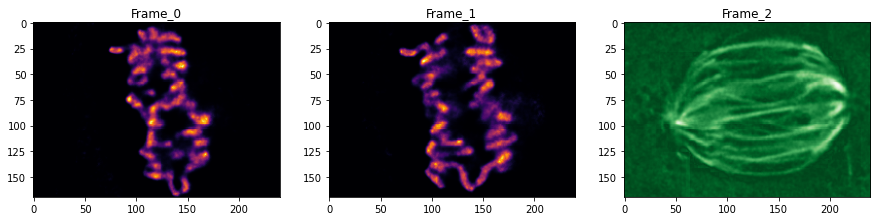

In [9]:
with pyczi.open_czi(czifile_5dstack) as czidoc:

    # define some plane coordinates
    plane_1 = {'C': 0, 'Z': 2, 'T': 1}
    plane_2 = {'C': 1, 'Z': 3, 'T': 2}

    # equivalent to reading {'C': 0, 'Z': 0, 'T': 0}
    frame_0 = czidoc.read()

    # get the shape of the 2d plane - the last dime indicates the pixel type
    # 3 = BGR and 1 = Gray
    print("Array Shape: ", frame_0.shape)

    # get specific planes 
    frame_1 = czidoc.read(plane=plane_1)
    frame_2 = czidoc.read(plane=plane_2)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(frame_0, cmap=cm.inferno)
    ax[0].set_title("Frame_0")
    ax[1].imshow(frame_1, cmap=cm.inferno)
    ax[1].set_title("Frame_1")
    ax[2].imshow(frame_2, cmap=cm.Greens_r)
    ax[2].set_title("Frame_2")



### Read ROI inside a specific 2D plane
We can also read an ROI within the plane.
This is particularly useful when dealing with large images whose planes would not fit into memory.

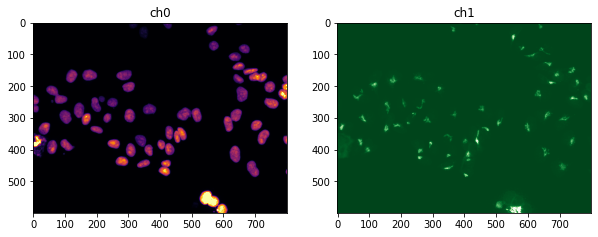

In [10]:
# define the ROI using upper left, widht and height as coordinates
my_roi = (200, 400, 800, 600)

with pyczi.open_czi(czifile_scenes) as czidoc:
    ch0 = czidoc.read(roi=my_roi, plane={'C': 0})
    ch1 = czidoc.read(roi=my_roi, plane={'C': 1})

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(ch0, cmap=cm.inferno, vmin=100, vmax=4000)
    ax[0].set_title("ch0")
    ax[1].imshow(ch1, cmap=cm.Greens_r, vmin=100, vmax=4000)
    ax[1].set_title("ch1")


### Read ROI only for one scene
We can also get pixel data exclusively from one scene only using the scene parameter.

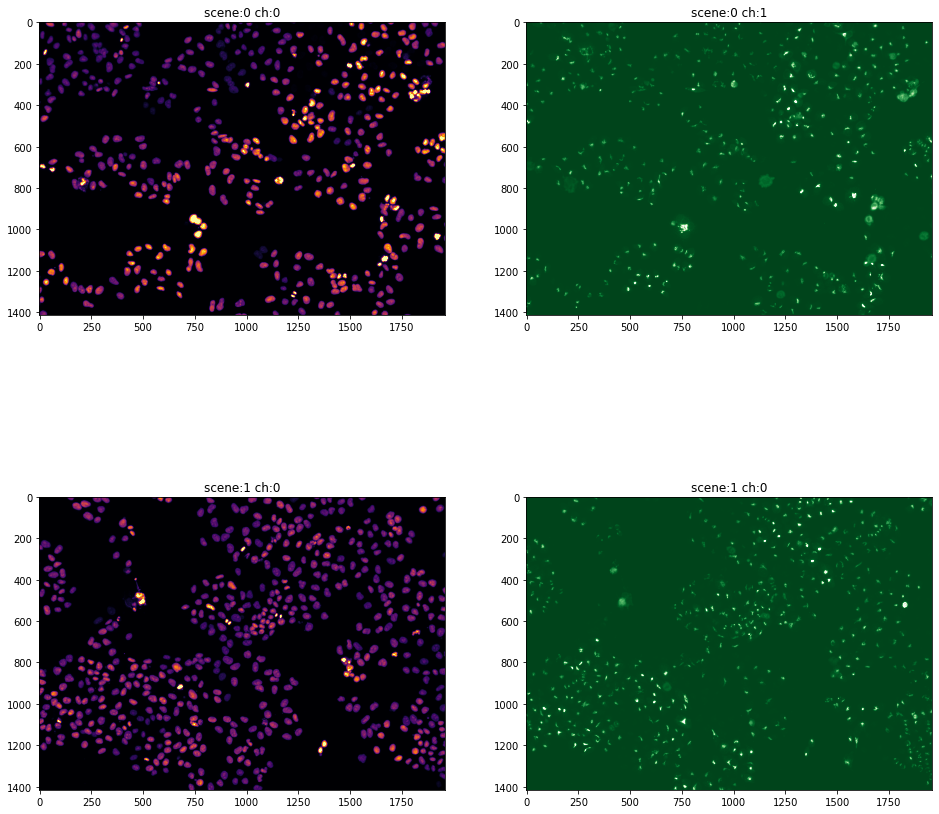

In [11]:
with pyczi.open_czi(czifile_scenes) as czidoc:

    # read a 2D image from a specific channel and scene
    c0_s0 = czidoc.read(plane={'C': 0}, scene=0)
    c1_s0 = czidoc.read(plane={'C': 1}, scene=0)
    c0_s1 = czidoc.read(plane={'C': 0}, scene=1)
    c1_s1 = czidoc.read(plane={'C': 1}, scene=1)
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    ax[0, 0].imshow(c0_s0, cmap=cm.inferno, vmin=100, vmax=4000)
    ax[0, 0].set_title("scene:0 ch:0")
    ax[0, 1].imshow(c1_s0, cmap=cm.Greens_r, vmin=100, vmax=4000)
    ax[0, 1].set_title("scene:0 ch:1")
    ax[1, 0].imshow(c0_s1, cmap=cm.inferno, vmin=100, vmax=4000)
    ax[1, 0].set_title("scene:1 ch:0")
    ax[1, 1].imshow(c1_s1, cmap=cm.Greens_r, vmin=100, vmax=4000)
    ax[1, 1].set_title("scene:1 ch:0")


### Additional parameters

We can specify the pixel type in which we want the data. If we don't specify any, the data is returned in its original pixel format.
The shape of the numpy array will naturally depend on the chosen pixel type.

In [12]:
with pyczi.open_czi(czifile_5dstack) as czidoc:

    # get image pixel and specify the desired pixel type
    frame_gray8 = czidoc.read(pixel_type='Gray8')
    frame_gray32float = czidoc.read(pixel_type='Gray32Float')
    frame_bgr48 = czidoc.read(pixel_type='Bgr48')

    print('shape {0}, data type {1}'.format(frame_gray8.shape, frame_gray8.dtype))
    print('shape {0}, data type {1}'.format(frame_gray32float.shape, frame_gray32float.dtype))
    print('shape {0}, data type {1}'.format(frame_bgr48.shape, frame_bgr48.dtype))

shape (170, 240, 1), data type uint8
shape (170, 240, 1), data type float32
shape (170, 240, 3), data type uint16


We can also specify a zoom factor between 0 and 1:

Shape Zoomlevel =  1.0 (300, 300, 1)
Shape Zoomlevel =  0.25 (75, 75, 1)


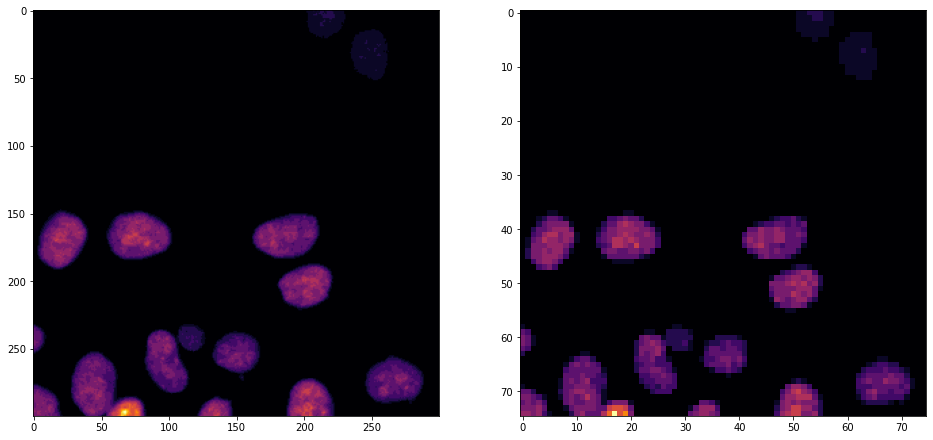

In [13]:
# define the ROI using upper left, widht and height as coordinates
my_roi = (300, 400, 300, 300)
zl1 = 1.0
zl2 = 0.25

with pyczi.open_czi(czifile_scenes) as czidoc:
    z1 = czidoc.read(plane={'C': 0}, roi=my_roi, scene=0, zoom=zl1, pixel_type='Gray8')
    z2 = czidoc.read(plane={'C': 0}, roi=my_roi, scene=0, zoom=zl2, pixel_type='Gray8')

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(z1, cmap=cm.inferno)
    ax[1].imshow(z2, cmap=cm.inferno)

    print("Shape Zoomlevel = ", zl1, z1.shape)
    print("Shape Zoomlevel = ", zl2, z2.shape)


## Writing a CZI file

The writing API only allows creating new czi files. Editing existing czi file is not supported.
The writing API is somewhat symmetrical to the reading API.

### Create a new CZI
Similarly to reading, before writing, we must create a czi instance. We can then write to the created instance.

### Write data
Writing pixel data is very similar to reading albeit with fewer parameters.

We can define the plane to which we want to write the data.

The data to be written is also provided as a numpy array,
and the pixel type in which it is written is automatically determined from the shape of the array and its data type.

In [14]:
from skimage import data

data = data.kidney()

print(f'number of dimensions: {data.ndim}')
print(f'shape: {data.shape}')
print(f'dtype: {data.dtype}')

number of dimensions: 4
shape: (16, 512, 512, 3)
dtype: uint16


In [15]:
newczi_1 = os.path.join(os.getcwd(), "newCZI_z=16_ch=3.czi")
numCH = 3
numZ = 16

# open a new CZI and allow overwrite (!!!) to play around ...
with pyczi.create_czi(newczi_1, exist_ok=True) as czidoc_w:
    
    # loop over all z-planes and channels
    for z, ch in it.product(range(numZ), range(numCH)):
        
        # get the 2d array for the current plane
        array2d = data[z, ..., ch][..., np.newaxis]
        
        # write the plane with shape (Y, X, 1) to the new CZI file
        czidoc_w.write(data=array2d, plane={"Z": z, "C": ch})

  0%|          | 0/48 [00:00<?, ?it/s]

<p><img src="images\new_czi_z=16_c=3.png" title="newCZI_z=16_ch=3.czi - shown in ZEN blue" width="1000"></p>

We can also write data to a specific location within the plane by providing the upper left pixel coordinates. To illustrate this idea let's write all z-planes from the image side-by-side into one new CZI image.

In [16]:
newczi_2 = os.path.join(os.getcwd(), "newCZI_zplanes2loc.czi")
xstart = 0
ch = 0

with pyczi.create_czi(newczi_2, exist_ok=True) as czidoc_w:
    
    # loop over all z-planes
    for z in tqdm(range(numZ)):
        
        # get the 2d array for the current plane
        array2d = data[z, ..., ch][..., np.newaxis]
        
    
        # for fun - write the z-planes to different locations
        czidoc_w.write(data=array2d, plane={"C": ch}, location=(xstart, 0))
        
        # change the x-position for the next round
        xstart = xstart + 512

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 213.23it/s]


<p><img src="images\new_czi_locations.png" title="new_czi_locations.czi - shown in ZEN blue" width="1000"></p>

### Write scenes

Writing a scene is in fact "just" writing pixel data to a specific plane and tagging it with a **scene** index. To illustrate this we now will write the z-planes to different scenes at different locations

In [17]:
# first step is to create some kind of grid of locations
locx = []
locy = []
xystart = 0
offset = 700

# create the list for the 4x4 grid locations for the 16 planes 
for x,y in it.product(range(4), range(4)):
    locx.append(xystart + offset * x)
    locy.append(xystart + offset * y)

  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
newczi_3 = os.path.join(os.getcwd(), "newCZI_zplanes2scenes.czi")
ch = 1

with pyczi.create_czi(newczi_3, exist_ok=True) as czidoc_w:
    
    # loop over all z-planes
    for z in tqdm(range(numZ)):
        
        # get the 2d array for the current plane
        array2d = data[z, ..., ch][..., np.newaxis]
        
        # for fun - write the z-planes to different locations using the locations we just created
        czidoc_w.write(data=array2d, plane={"C": ch}, scene=z, location=(locx[z], locy[z]))

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 144.14it/s]


<p><img src="images\new_czi_scenes.png" title="new_czi_scenes - shown in ZEN blue" width="900"></p>

### Write Metadata

It is possible to write "some" metadata and providing the following **optional** parameters:

- document name (in ZEN: "Title")
- channel names (in ZEN: "Channel Names"
- scaling in XYZ with unit meters (in ZEN: "Scaling (per Pixel)")

This list of parameters will be extended on a case-by-case basis in the future.

***

#### Important Remark

If no metadata was written, the default metadata is automatically written upon closing the document.

In [19]:
newczi_4 = os.path.join(os.getcwd(), "new_czi_z=16.czi")
numZ = 16

# open a new CZI and allow overwrite (!!!) to play around ...
with pyczi.create_czi(newczi_4, exist_ok=True) as czidoc_w:
    
    # loop over all z-planes
    for z in tqdm(range(numZ)):
        
        # get the 2d array for the current plane
        array2d = data[z, ..., 0][..., np.newaxis]
        
        # write the plane with shape (Y, X, 1) to the new CZI file
        czidoc_w.write(data=array2d, plane={"Z": z})
    
    # write the document title, channel names and XYZ scaling to the CZI file
    czidoc_w.write_metadata(document_name='new_czi_z=16',
                             channel_names={ 0: "Red"},
                             scale_x=0.1 * 10**-6,
                             scale_y=0.1 * 10**-6,
                             scale_z=0.3 * 10**-6)

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 192.78it/s]


<p><img src="images\new_czi_z=16_metadata.png" title="new_czi_z=16_metadata - shown in ZEN blue" width="900"></p>

## Tiling a large image

The read and write API allow us to work with large images by breaking down the access into "tiles".
However, defining this tiles can be a cumbersome process.

The czitile package was created to answer this need.

This package contains pure logic for tiling rectangles and is not IO nor format bound.

Let's read the original file using cztile and write a new with the same dimensions and scenes but with
random data instead.

In [20]:
from skimage.filters import gaussian

# define a generic 2D processing function - could by a DL segmentation as well
def process2d(image2d: np.ndarray, **kwargs: int) -> np.ndarray:

    # insert or modify the desired processing function here
    image2d = gaussian(image2d, sigma=kwargs["sigma"],
                       preserve_range=True,
                       mode='nearest').astype(image2d.dtype)

    return image2d

In [21]:
newczi_5 = os.path.join(os.getcwd(), "new_czi_tilewise.czi")
czifile_orig = r"DAPI_PGC.czi"

# get the CZI metadata 
with pyczi.open_czi(czifile_orig) as czidoc_r:
    mdata = czidoc_r.metadata
    sbr = czidoc_r.scenes_bounding_rectangle[0]

# get the XY dimensions from the metadata
sizeX = int(mdata["ImageDocument"]["Metadata"]["Information"]["Image"]["SizeX"])
sizeY = int(mdata["ImageDocument"]["Metadata"]["Information"]["Image"]["SizeY"])

In [61]:
# import the "tiling strategy" from the cztile package
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D
from cztile.tiling_strategy import Rectangle as czrect

# create a "tile" by specifying the desired tile dimension and the
# minimum required overlap between tiles (depends on the processing)
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(total_tile_width=1600,
                                                  total_tile_height=1400,
                                                  min_border_width=128)

# create the tiles
tiles = tiler.tile_rectangle(czrect(x=0, y=0, w=sbr.w, h=sbr.h))
    
# show the cretaed tile locations
for tile in tiles:
    print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

0 0 1600 1400
0 808 1600 1400
1152 0 1600 1400
1152 808 1600 1400


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


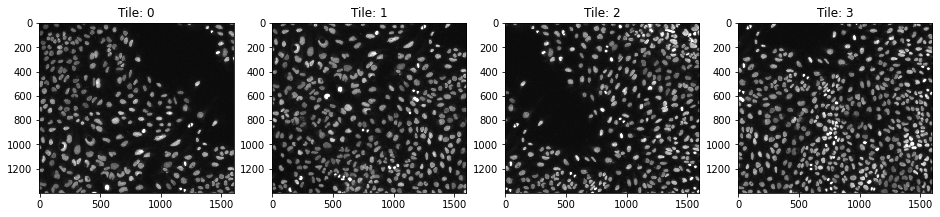

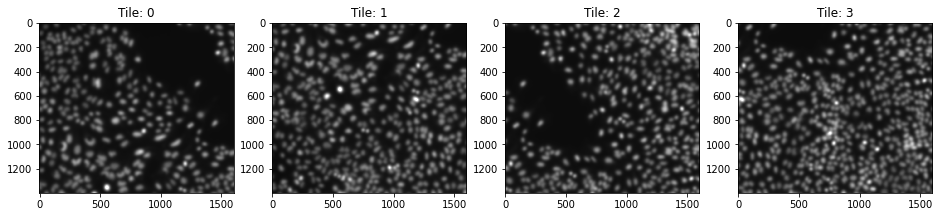

In [62]:
# open an existing CZI file for reading planes and a new CZI to insert
# the newly processed chunks into the new CZI file

fig1, ax1 = plt.subplots(1, 4, figsize=(16, 8))
fig2, ax2 = plt.subplots(1, 4, figsize=(16, 8))
a = 0

with pyczi.open_czi(czifile_orig) as czidoc_r:
    with pyczi.create_czi(newczi_5, exist_ok=True) as czidoc_w:

        # loop over all tiles
        for tile in tqdm(tiles):
            
            # read a specific tile from the CZI
            tile2d = czidoc_r.read(plane={"C": 0},
                                           roi=(tile.roi.x,
                                                tile.roi.y,
                                                tile.roi.w,
                                                tile.roi.h))
            
            # process the current tile
            tile2d_processed = process2d(tile2d, sigma=11)
            
            # show some figures to illustrate the idea
            ax1[a].imshow(tile2d, interpolation="nearest", cmap="gray",vmin=100, vmax=4000)
            ax1[a].set_title("Tile: " + str(a))
            ax2[a].imshow(tile2d_processed, interpolation="nearest", cmap="gray", vmin=100, vmax=4000)
            ax2[a].set_title("Tile: " + str(a))
                                                                          
            # write the new CZI file using the processed data
            czidoc_w.write(tile2d_processed,
                           plane={"C": 0},
                           location=(tile.roi.x, tile.roi.y))
            
            a += 1

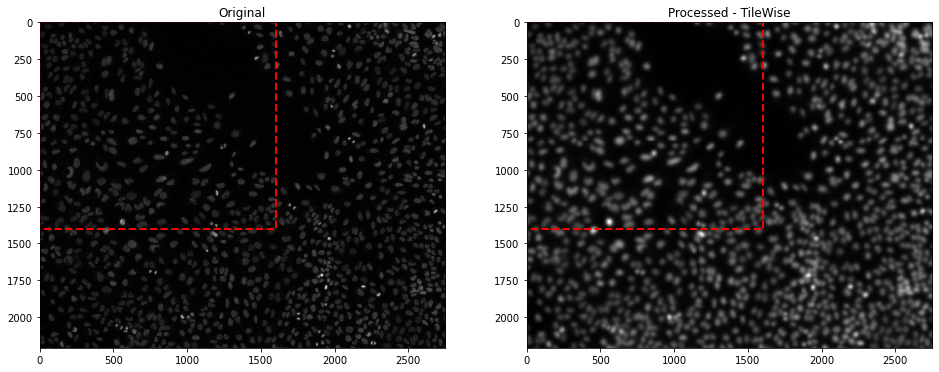

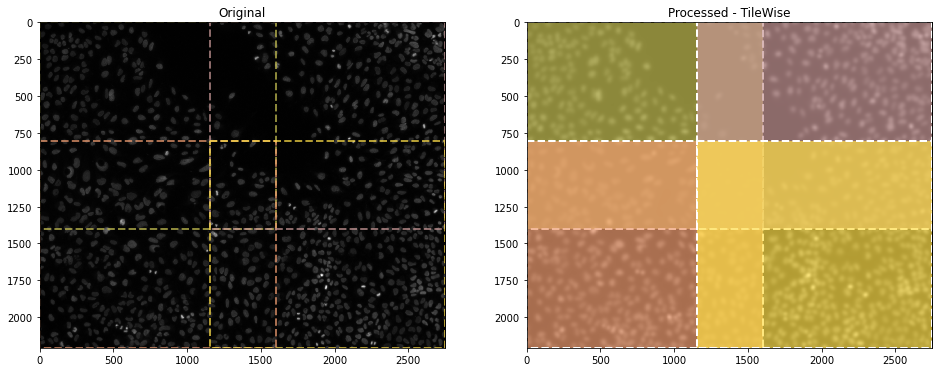

In [63]:
import random

# read the CZI pixel data
with pyczi.open_czi(czifile_orig) as czidoc_r:
    data_orig = czidoc_r.read(plane={"C": 0})
    
with pyczi.open_czi(newczi_5) as czidoc_r:
    data_processed = czidoc_r.read(plane={"C": 0})


# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(data_orig, interpolation="nearest", cmap="gray")
ax1.set_title('Original')
ax2.imshow(data_processed, interpolation="nearest", cmap="gray")
ax2.set_title('Processed - TileWise')

# define the tile to be shown
tn = 0
 
#add rectangle to plot
ax1.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

ax2.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

# show the results
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
ax3.imshow(data_orig, interpolation="nearest", cmap="gray")
ax3.set_title('Original')
ax4.imshow(data_processed, interpolation="nearest", cmap="gray")
ax4.set_title('Processed - TileWise')


edge_color_opacity = 1.0
face_color_opacity = 0.7

# visualize a single tile
for tile in tiles:
    
    r = random.random()
    b = random.random()
    g = random.random()
    edgecolor = (r, g, b, face_color_opacity)
    facecolor = (r, g, b, face_color_opacity)
    
    # add rectangle to plot
    ax3.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=edgecolor,
                  fill=False,
                  lw=2,
                  ls="--"))

    ax4.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=(1, 1, 1, edge_color_opacity),
                  facecolor=facecolor,          
                  fill=True,
                  lw=2,
                  ls="--"))